# Question 2

To implement Batch Gradient Decent i refer to the reserch paper by IBM

https://developer.ibm.com/articles/implementing-logistic-regression-from-scratch-in-python/


also here is a quick steps explanation of gradient decent is calculated

1. First split the data into two three segments,
    - 70 % --> training
    - 15 % --> test
    - 15 % --> validation

2. We need to applying scaling to data to get ssome presentable results: 
we can use either min-max or standard scaling.

3. Then we run logistic regression to our scaled data set which is implemented using batch gradient decent with 4500 iterations or epoches.

4. Then did Graph and Accuracy analysis.

### Importing Libraries

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt

### function to load the dataset using CSV builtin library.

In [2]:
def load_csv(name):
    data_loaded = []
    with open(name, 'r') as file:
        csvreader = csv.reader(file)
        header = next(csvreader)
        for row in csvreader:
            processed_row = [float(value) if value != 'NA' else np.nan for value in row]
            data_loaded.append(processed_row)
    return header, np.array(data_loaded)

### Filling missing values for the data

In [3]:
def filling_missing_values(data_loaded):
    col_values_to_replace = np.nanmean(data_loaded, axis=0)
    for i in range(data_loaded.shape[1]):
        data_loaded[:, i] = np.where(np.isnan(data_loaded[:, i]), col_values_to_replace[i], data_loaded[:, i])
    return data_loaded

### Functions to scale the values

In [4]:
# Min-Max-Scaling function
def min_max_scaler(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

# Standard-Scaling function
def standard_scaler(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    scaledx = (X - mean) / std
    return scaledx

### Function to split the data into 70:15:15 and fixing a random state 42


In [5]:
def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    np.random.seed(random_state)
    
    indexes = np.arange(X.shape[0])
    
    np.random.shuffle(indexes)
    
    X_data_shuffled = X[indexes]
    y_data_shuffled = y[indexes]
    
    train_end = int(train_size * len(X))
    val_end = int((train_size + val_size) * len(X))
    
    X_train, X_val, X_test = X_data_shuffled[:train_end], X_data_shuffled[train_end:val_end], X_data_shuffled[val_end:]
    y_train, y_val, y_test = y_data_shuffled[:train_end], y_data_shuffled[train_end:val_end], y_data_shuffled[val_end:]
    
    return X_train, X_val, X_test, y_train, y_val, y_test


### Finally loading the data

In [6]:

headers1, data_loaded1 = load_csv('Heart Disease.csv')
data_loaded1 = filling_missing_values(data_loaded1)

X = data_loaded1[:, :-1]
y = data_loaded1[:, -1]

### Applying Scaling:
you can change between scaling no scaling and min-max scaling

1. No-scaling --> simply comment out this cell
2. Standard-Scaling --> simply call the standard_scaler(X) function
3. Min-Max-Scaling --> simply call the min_max_scaler(X) function

In [7]:
X = standard_scaler(X)

### Splitting data using the function

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

### Checking shapes of the splitted data

In [9]:
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Training data shape: (2966, 15) (2966,)
Validation data shape: (636, 15) (636,)
Test data shape: (636, 15) (636,)


### Function to check if the random state is fixed or not(OPTIONAL)

In [10]:
def check_fixed_random_state(X, y, random_state=42, num_checks=3):
    # Perform the first split
    X_train_1, X_val_1, X_test_1, y_train_1, y_val_1, y_test_1 = split_data(X, y, random_state=random_state)
    
    # Run the split multiple times and check consistency
    for i in range(1, num_checks):
        X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, random_state=random_state)
        
        # Compare the splits
        if not (np.array_equal(X_train_1, X_train) and np.array_equal(y_train_1, y_train) and
                np.array_equal(X_val_1, X_val) and np.array_equal(y_val_1, y_val) and
                np.array_equal(X_test_1, X_test) and np.array_equal(y_test_1, y_test)):
            print(f"Random state is not fixed, Mismatch found after checking on {i+1}.")
            return False
        
    print(f"Random state is fixed, Splits are consistent across all of the {num_checks} checks.")
    return True


# Check if the random state is fixed
check_fixed_random_state(X, y, random_state=42, num_checks=5)

Random state is fixed, Splits are consistent across all of the 5 checks.


True

### Logistic regression class named LogisticRegression1 created using IBM research paper.
This class applies logistic regression fromm scrach by calculating gradients and updating weights and bias after each iteration.

In [11]:
class LogisticRegression1:
    def __init__(self, lr, epochs):
        self.lr = lr
        self.epochs = epochs
        self.theta = None
        self.bias = None
        self.training_accuracies = []
        self.validation_accuracies = []
        self.training_losses = []
        self.validation_losses = []

    def sigmoid_function_values(self, x):
        return np.array([self.sigmoid_function(value) for value in x])

    def sigmoid_function(self, x):
        if x >= 0:
            z = np.exp(-x)
            return 1 / (1 + z)
        else:
            z = np.exp(x)
            return z / (1 + z)

    def computeing_loss(self, y_true, y_predicted):
        E = 1e-9
        y_predicted = np.clip(y_predicted, E, 1 - E)
        loss = -np.mean(y_true * np.log(y_predicted) + (1 - y_true) * np.log(1 - y_predicted))
        return loss

    def gradients_for_bias_and_weights(self, X, y_true, y_pred):
        error = y_pred - y_true
        gradient_w = (np.dot(X.T, error)) / (X.shape[0])
        gradient_b = np.mean(error)
        return gradient_w, gradient_b

    def update_gradients_after_each_iteration(self, gradient_w, gradient_b):
        self.theta = self.theta -  self.lr * gradient_w
        self.bias = self.bias - self.lr * gradient_b

    def fit(self, X_train, y_train, X_val, y_val):
        num_features = X_train.shape[1]
        self.theta = np.ones(num_features)
        self.bias = 0
        
        for epoch in range(self.epochs + 1):
            z = np.dot(X_train, self.theta) + self.bias
            
            y_pred_train = self.sigmoid_function_values(z)
            
            training_loss = self.computeing_loss(y_train, y_pred_train)
            
            gradient_w, gradient_b = self.gradients_for_bias_and_weights(X_train, y_train, y_pred_train)
            self.update_gradients_after_each_iteration(gradient_w, gradient_b)


            z_value = np.dot(X_val, self.theta) + self.bias
            y_pred_value = self.sigmoid_function_values(z_value)
            
            valiadation_loss = self.computeing_loss(y_val, y_pred_value)

            training_accuracy = np.mean((y_pred_train > 0.5).astype(int) == y_train)
            validation_accuracy = np.mean((y_pred_value > 0.5).astype(int) == y_val)

            self.training_losses.append(training_loss)
            self.validation_losses.append(valiadation_loss)
            self.training_accuracies.append(training_accuracy)
            self.validation_accuracies.append(validation_accuracy)
            
        
        print("Data Trained Successfully:)")
     

## A)
Implement Logistic Regression using Batch Gradient Descent. Plot training loss vs. iteration, validation loss vs. iteration, training accuracy vs. iteration, and validation accuracy vs. iteration. Comment on the convergence of the model.
Compare and analyze the plots.

### Running the model

In [12]:
lr=0.01
epochs=4500

model1 = LogisticRegression1(lr, epochs)
model1.fit(X_train, y_train, X_val, y_val)

Data Trained Successfully:)


### Plotting Graphs and saving graphs as Part_A_results.png

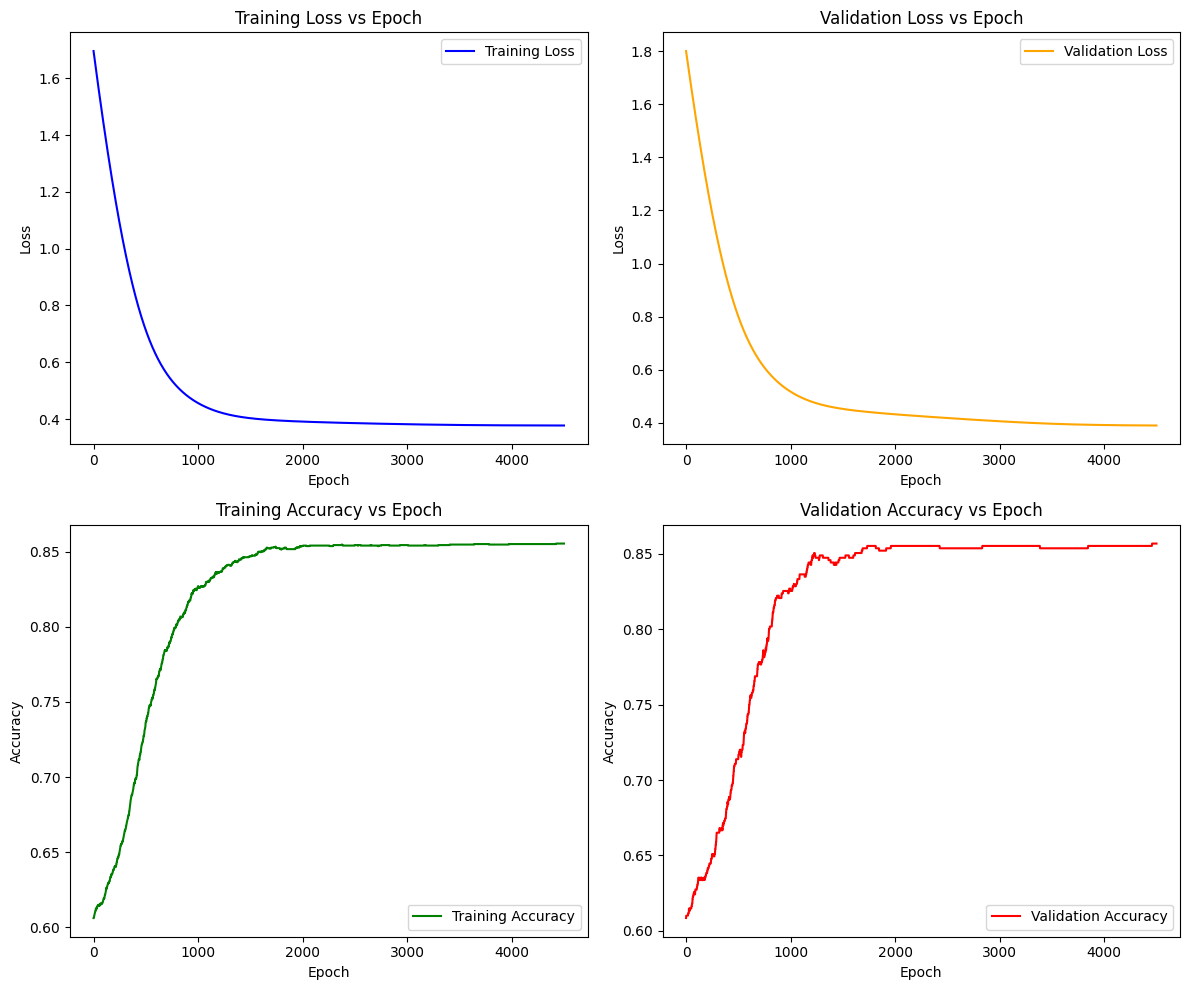

In [13]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(model1.training_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(model1.validation_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(model1.training_accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epoch')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(model1.validation_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('Part_A_results.png')
plt.show()

### Analysing the plots

it is evident from the above plots that the plots smoothly converges to acuracy values near to 0.85 which we will calculate in other parts of the question.

### Comparing the plots and saving file as Comparison_results_A.png

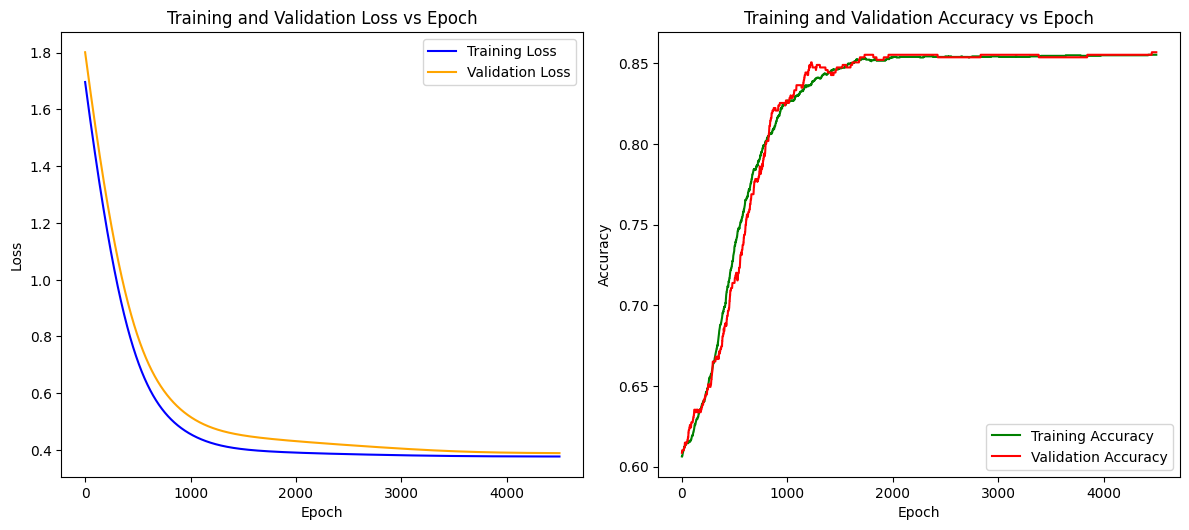

In [14]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(model1.training_losses, label='Training Loss', color='blue')
plt.plot(model1.validation_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(model1.training_accuracies, label='Training Accuracy', color='green')
plt.plot(model1.validation_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('Comparison_results_A.png')
plt.show()

It can be analysed from the above comparison that the loss for the training and validation is very close that means our model is consistant.

same results can be analysed from the model accuracy also.

## B)

Investigate and compare the performance of the model with different feature scaling methods: Min-max scaling and No scaling. Plot the loss vs. iteration for each method and discuss the impact of feature scaling on model convergence.

## Comparing no-scaling vs min-max-scaling

1. Starting with min-max-scaling

In [15]:
headers2, data_loaded2 = load_csv('Heart Disease.csv')
data_loaded2 = filling_missing_values(data_loaded2)

X = data_loaded2[:, :-1]
y = data_loaded2[:, -1]

X = min_max_scaler(X)

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)


model2 = LogisticRegression1(lr, epochs)
model2.fit(X_train, y_train, X_val, y_val)

Data Trained Successfully:)


### Storing min-max-scaling results

In [16]:
training_losses_min_max_scaling=model2.training_losses
validation_losses_min_max_scaling=model2.validation_losses
training_accuracies_min_max_scaling=model2.training_accuracies
validation_accuracies_min_max_scaling=model2.validation_accuracies

2. Applying no-scaling

In [17]:
headers3, data_loaded3 = load_csv('Heart Disease.csv')
data_loaded3 = filling_missing_values(data_loaded3)

X = data_loaded3[:, :-1]
y = data_loaded3[:, -1]

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)


model3 = LogisticRegression1(lr, epochs)
model3.fit(X_train, y_train, X_val, y_val)

Data Trained Successfully:)


### Storing no-scaling results

In [18]:
training_losses_no_scaling=model3.training_losses
validation_losses_no_scaling=model3.validation_losses
training_accuracies_no_scaling=model3.training_accuracies
validation_accuracies_no_scaling=model3.validation_accuracies

### Comparing no-scaling and min-max-scaling plots

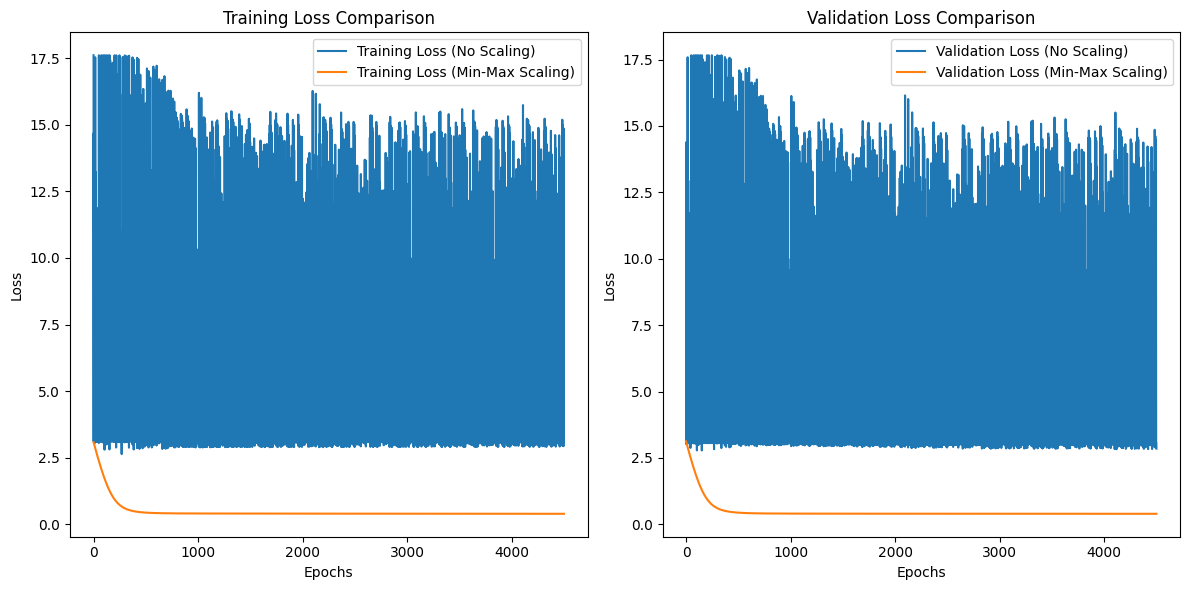

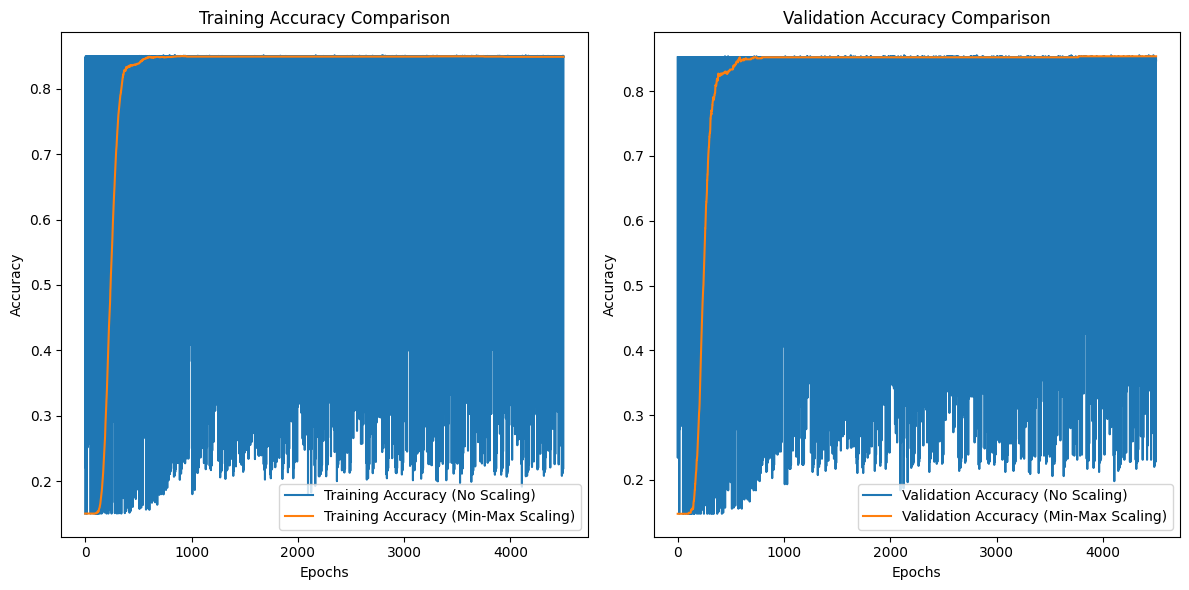

In [19]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(training_losses_no_scaling, label='Training Loss (No Scaling)')
plt.plot(training_losses_min_max_scaling, label='Training Loss (Min-Max Scaling)')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(validation_losses_no_scaling, label='Validation Loss (No Scaling)')
plt.plot(validation_losses_min_max_scaling, label='Validation Loss (Min-Max Scaling)')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(training_accuracies_no_scaling, label='Training Accuracy (No Scaling)')
plt.plot(training_accuracies_min_max_scaling, label='Training Accuracy (Min-Max Scaling)')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(validation_accuracies_no_scaling, label='Validation Accuracy (No Scaling)')
plt.plot(validation_accuracies_min_max_scaling, label='Validation Accuracy (Min-Max Scaling)')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("Question_2_B_comparison.png")
plt.show()

## Individual model Plots

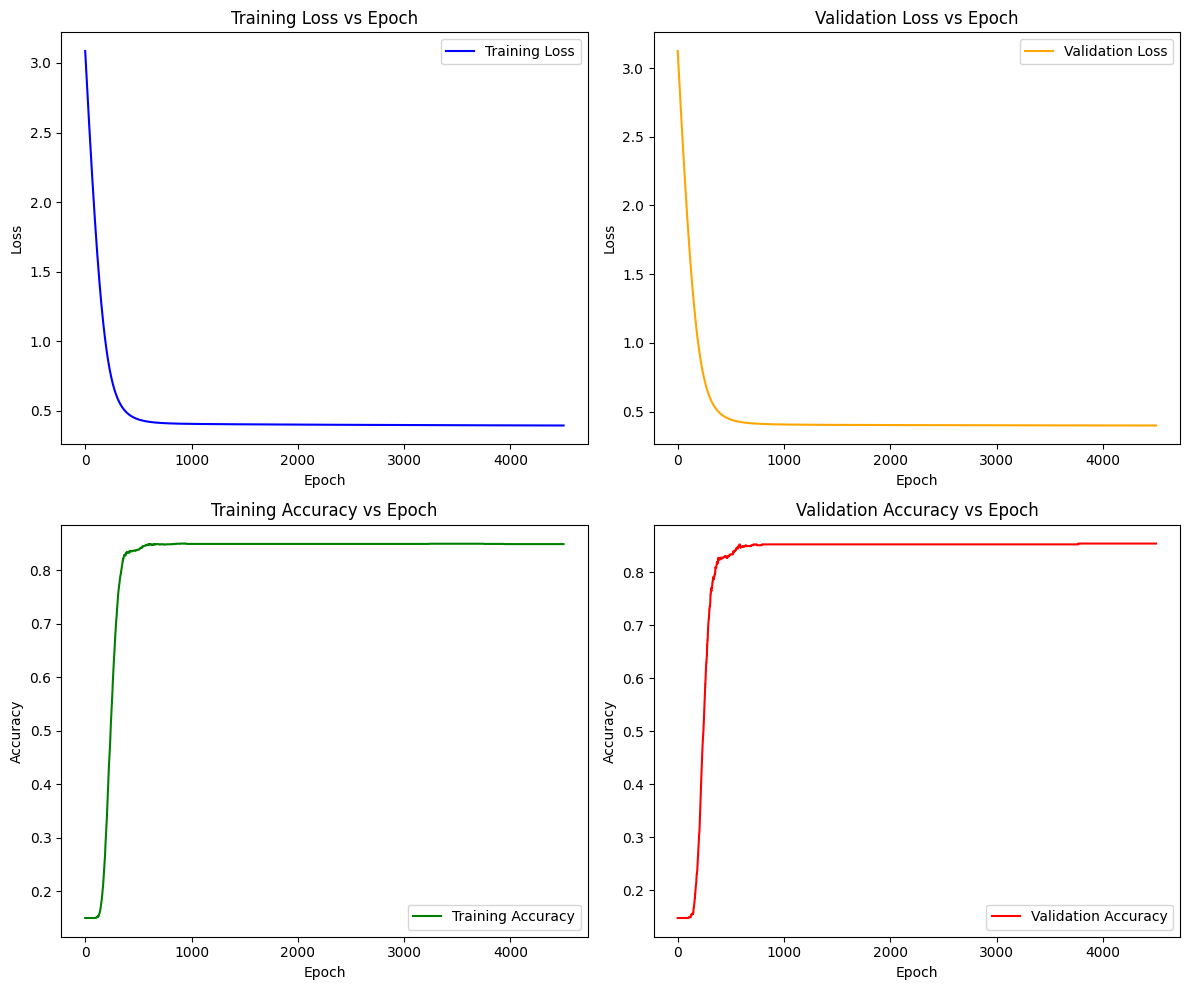

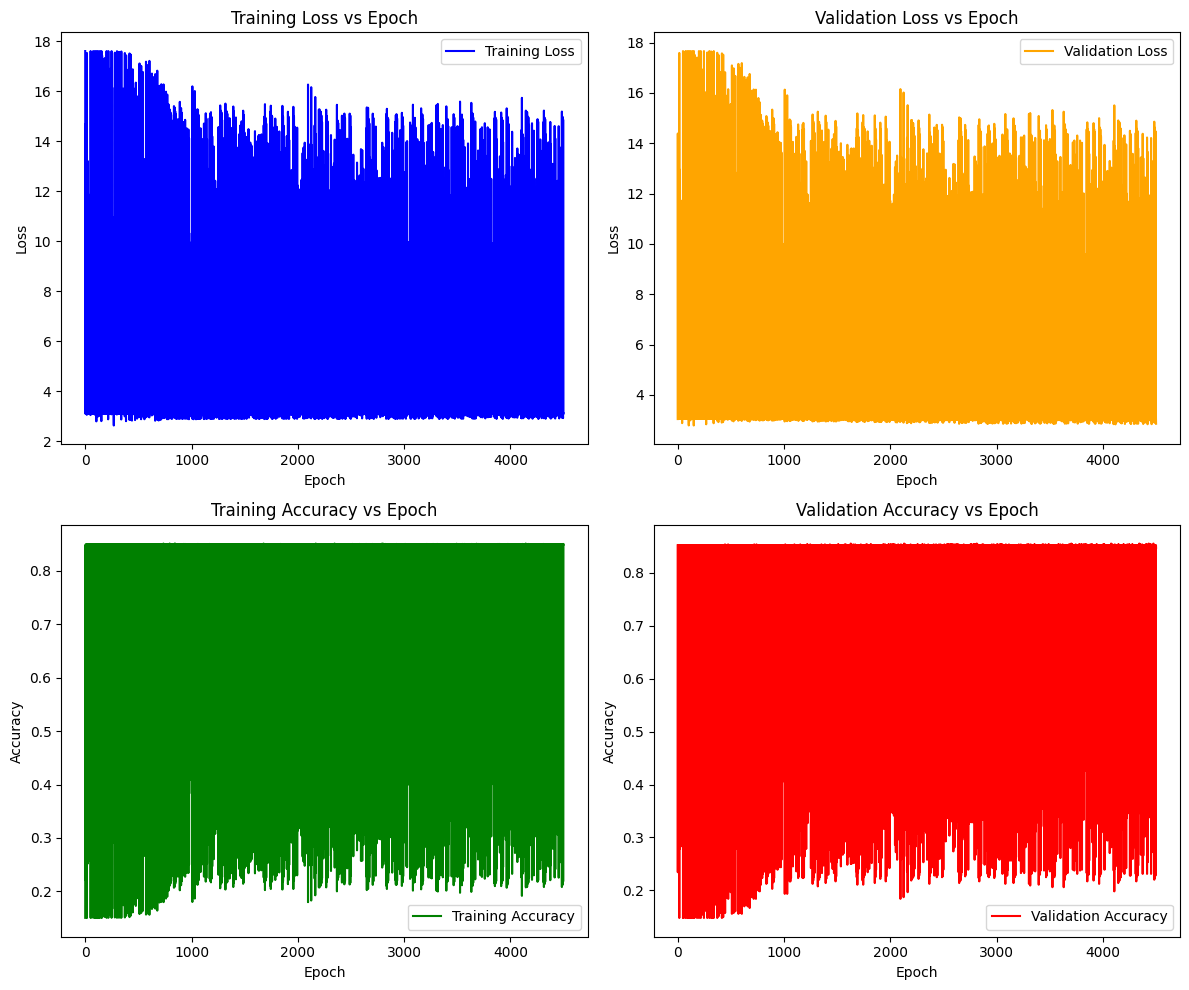

In [20]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(training_losses_min_max_scaling, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(validation_losses_min_max_scaling, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(training_accuracies_min_max_scaling, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epoch')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(validation_accuracies_min_max_scaling, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('Question_2_B_individual_plots_min_max_scaling.png')
plt.show()





plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(training_losses_no_scaling, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(validation_losses_no_scaling, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(training_accuracies_no_scaling, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epoch')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(validation_accuracies_no_scaling, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('Question_2_B_individual_plots_no_scaling.png')
plt.show()

### Analysing results

we can analyse from the above graphs that for no scalinng the graph came very distorted but it shows same results like the scaled version that the loss is decreasing and the accuracies are increasing.
both the model converges but the scaled model converges better because it eliminates ossilations.

## C)

Calculate and present the confusion matrix for the validation set. Report precision, recall, F1 score, and ROC-AUC score for the model based on the validation set. Comment on how these metrics provide insight into the model’s performance.

### Analysing for Standard scaler model

### LR class fullfilling the requirements of Q2-Part-C

In [21]:
class LogisticRegression2:
    def __init__(self, learning_rate, epochs):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.training_accuracies = []
        self.validation_accuracies = []
        self.training_losses = []
        self.validation_losses = []

    def sigmoid_function_values(self, x):
        return np.array([self.sigmoid_function(value) for value in x])

    def sigmoid_function(self, x):
        if x >= 0:
            z = np.exp(-x)
            return 1 / (1 + z)
        else:
            z = np.exp(x)
            return z / (1 + z)

    def computeing_loss(self, y_true, y_predicted):
        E = 1e-9
        y_predicted = np.clip(y_predicted, E, 1 - E)
        loss = -np.mean(y_true * np.log(y_predicted) + (1 - y_true) * np.log(1 - y_predicted))
        return loss

    def gradients_for_bias_and_weights(self, X, y_true, y_pred):
        error = y_pred - y_true
        gradient_w = (np.dot(X.T, error)) / (X.shape[0])
        gradient_b = np.mean(error)
        return gradient_w, gradient_b

    def update_gradients_after_each_iteration(self, gradient_w, gradient_b):
        self.weights = self.weights -  self.lr * gradient_w
        self.bias = self.bias - self.lr * gradient_b

    def fit(self, X_train, y_train, X_val, y_val):
        num_features = X_train.shape[1]
        self.weights = np.ones(num_features)
        self.bias = 0
        
        for epoch in range(self.epochs + 1):
            z = np.dot(X_train, self.weights) + self.bias
            y_pred_train = self.sigmoid_function_values(z)
            
            training_loss = self.computeing_loss(y_train, y_pred_train)
            gradient_w, gradient_b = self.gradients_for_bias_and_weights(X_train, y_train, y_pred_train)
            self.update_gradients_after_each_iteration(gradient_w, gradient_b)

            z_value = np.dot(X_val, self.weights) + self.bias
            y_pred_value = self.sigmoid_function_values(z_value)
            
            valiadation_loss = self.computeing_loss(y_val, y_pred_value)

            training_accuracy = np.mean((y_pred_train > 0.5).astype(int) == y_train)
            validation_accuracy = np.mean((y_pred_value > 0.5).astype(int) == y_val)

            self.training_losses.append(training_loss)
            self.validation_losses.append(valiadation_loss)
            self.training_accuracies.append(training_accuracy)
            self.validation_accuracies.append(validation_accuracy)
            
        
        print("Data Trained Successfully:)")
        
    def accuracy_calculation(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def precision_calculation(self, y_true, y_pred):
        TP = np.sum((y_pred == 1) & (y_true == 1))
        FP = np.sum((y_pred == 1) & (y_true == 0))
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        return precision

    def recall_calculation(self, y_true, y_pred):
        TP = np.sum((y_pred == 1) & (y_true == 1))
        FN = np.sum((y_pred == 0) & (y_true == 1))
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        return recall

    def f1_score_calculation(self, precision, recall):
        return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    def prediction(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid_function_values(z)
    
    def evaluate_metrics(self, y_true, y_pred, y_prob=None):
        
        TP, TN, FP, FN = self.confusion_matrix_calculation(y_true, y_pred)
        precision = self.precision_calculation(y_true, y_pred)
        recall = self.recall_calculation(y_true, y_pred)
        f1 = self.f1_score_calculation(precision, recall)
        print("Confusion Matrix:")
        print(f"TP: {TP}, FP: {FP}\nFN: {FN}, TN: {TN}")
        print()
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        if y_prob is not None:
            roc = self.ROC_calculation(y_true, y_prob)
            print(f"ROC-AUC: {roc:.4f}")

    def confusion_matrix_calculation(self, y_true, y_pred):
        TP = np.sum((y_pred == 1) & (y_true == 1))
        TN = np.sum((y_pred == 0) & (y_true == 0))
        FP = np.sum((y_pred == 1) & (y_true == 0))
        FN = np.sum((y_pred == 0) & (y_true == 1))
        return TP, TN, FP, FN

    def precision_calculation(self, y_true, y_pred):
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        return precision

    def recall_calculation(self, y_true, y_pred):
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        return recall

    def f1_score_calculation(self, precision, recall):
        return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    def ROC_calculation(self, y_true, y_prob):
        thresholds = np.sort(y_prob)[::-1]
        tpr = []
        fpr = []
        
        for threshold in thresholds:
            y_pred = (y_prob >= threshold).astype(int)
            tp, tn, fp, fn = self.confusion_matrix_calculation(y_true, y_pred)
            tpr.append(tp / (tp + fn) if (tp + fn) != 0 else 0) 
            fpr.append(fp / (fp + tn) if (fp + tn) != 0 else 0)
        
        auc = np.trapezoid(tpr, fpr)
        return auc
     

### Running model and printing evaluation matrix

In [22]:
headers4, data_loaded4 = load_csv('Heart Disease.csv')
data_loaded4 = filling_missing_values(data_loaded4)

X = data_loaded4[:, :-1]
y = data_loaded4[:, -1]

X = standard_scaler(X)

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

model4 = LogisticRegression2(lr, epochs)
model4.fit(X_train, y_train, X_val, y_val)

y_val_pred = (model4.prediction(X_val) > 0.5).astype(int)
y_val_prob = model4.prediction(X_val)

model4.evaluate_metrics(y_val, y_val_pred, y_val_prob)


Data Trained Successfully:)
Confusion Matrix:
TP: 9, FP: 6
FN: 85, TN: 536

Precision: 0.6000
Recall: 0.0957
F1 Score: 0.1651
ROC-AUC: 0.6860


### Analysis of the matrix


#### 1. Confusion Matrix:
|                | Predicted Negative | Predicted Positive |
|----------------|--------------------|--------------------|
| **Actual Negative** | 536                | 6                  |
| **Actual Positive** | 85                 | 9                  |

- **True Positives (TP)** = 9
- **False Positives (FP)** = 6
- **False Negatives (FN)** = 85
- **True Negatives (TN)** = 536

#### 2. Precision:
**Precision = TP / (TP + FP) = 9 / (9 + 6) = 0.6000**

**Interpretation**: 60% precision indicated the positive predictions that are correctly predicted my the model.

#### 3. Recall (Sensitivity or True Positive Rate):
**Recall = TP / (TP + FN) = 9 / (9 + 85) = 0.0957**

**Interpretation**: 9.57% recall signifies no of cases identified by the model that are actually positive.

#### 4. F1 Score:
**F1 Score = 2 * (Precision * Recall) / (Precision + Recall) = 2 * (0.6000 * 0.0957) / (0.6000 + 0.0957) = 0.1651**

**Interpretation**: The F1 score of 16.51 % shows that the model struggles to balance precision and recall this is because the number of positives is far less than no of negaives on which the data is trained.

#### 5. ROC-AUC Score:
**ROC-AUC = 0.6860**

**Interpretation**: The ROC-AUC score of 68.60 % represents moderate ability of the model to distinguish between the positive and negative classes.

#### 6. Comments on Model Performance:
- **High Precision, Low Recall**: The model has decent precision of 60 %, meaning that when it predicts heart disease it is more likely to be correct, but very low recall 9.57 % shows the model misses many true heart disease cases because most of the data feeded to the model is patients with no heart disease.
- **Low F1 Score**: The low F1 score of 16.51 % indicates the model is not performing well on positive case detection.
- **Moderate ROC-AUC**: The AUC score of 68.60 % represents the model can moderately distinguish between the positive and negative classes, but there's room for improvement.

#### 7. Actionable Insights:
- **Improve Recall**: Improve dataset by including more heart disease patients data.
- **Optimize Threshold**: Adjusting the probability threshold for predicting positive cases.
- **Model Refinement**: The model's performance can improve with hyperparameter tunin and regularization.


## D)

Implement and compare the following optimisation algorithms: Stochastic Gradient Descent and Mini-Batch Gradient Descent (with varying batch sizes, at least 2). Plot and compare the loss vs. iteration and accuracy vs. iteration for each method. Discuss the trade-offs in terms of convergence speed and stability between these methods.

### LR class fullfilling the requirements of Q2-Part-D

In [23]:
class LogisticRegression3:
    def __init__(self, lr, epochs, optimization, batch_size=16):
        self.lr = lr
        self.epochs = epochs
        self.optimization = optimization
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.train_losses = []
        self.train_accuracies = []

    def sigmoid_function_values(self, x):
        return np.array([self.sigmoid_function(value) for value in x])

    def sigmoid_function(self, x):
        if x >= 0:
            z = np.exp(-x)
            return 1 / (1 + z)
        else:
            z = np.exp(x)
            return z / (1 + z)

    def computeing_loss(self, y_true, y_predicted):
        E = 1e-9
        y_predicted = np.clip(y_predicted, E, 1 - E)
        loss = -np.mean(y_true * np.log(y_predicted) + (1 - y_true) * np.log(1 - y_predicted))
        return loss

    def gradients_for_bias_and_weights(self, X, y_true, y_pred):
        error = y_pred - y_true
        gradient_w = (np.dot(X.T, error)) / (X.shape[0])
        gradient_b = np.mean(error)
        return gradient_w, gradient_b

    def update_gradients_after_each_iteration(self, gradient_w, gradient_b):
        self.weights = self.weights -  self.lr * gradient_w
        self.bias = self.bias - self.lr * gradient_b

    def fit(self, X_train, y_train):
        num_features = X_train.shape[1]
        self.weights = np.ones(num_features)
        self.bias = 0

        for epoch in range(self.epochs):
            if self.optimization == "sgd":
                self.stochastic_gradient_descent_SGD(X_train, y_train)
            elif self.optimization == "mini-batch":
                self.mini_batch_gradient_descent_MGD(X_train, y_train, self.batch_size)
            else:
                self.batch_gradient_descent_BGD(X_train, y_train)
            y_pred_train = self.prediction(X_train)
            train_loss = self.computeing_loss(y_train, y_pred_train)
            train_acc = np.mean((y_pred_train > 0.5).astype(int) == y_train)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)

           
            

    def batch_gradient_descent_BGD(self, X_train, y_train):
        z = np.dot(X_train, self.weights) + self.bias
        y_pred = self.sigmoid_function_values(z)
        gradient_w, gradient_b = self.gradients_for_bias_and_weights(X_train, y_train, y_pred)
        self.update_gradients_after_each_iteration(gradient_w, gradient_b)

    def stochastic_gradient_descent_SGD(self, X_train, y_train):
        for i in range(X_train.shape[0]):
            xi = X_train[i:i+1]
            yi = y_train[i:i+1]
            z = np.dot(xi, self.weights) + self.bias
            y_pred = self.sigmoid_function_values(z)
            gradient_w, gradient_b = self.gradients_for_bias_and_weights(xi, yi, y_pred)
            self.update_gradients_after_each_iteration(gradient_w, gradient_b)

    def mini_batch_gradient_descent_MGD(self, X_train, y_train, batch_size):
        n = X_train.shape[0]
        indices = np.arange(n)
        np.random.shuffle(indices)

        for i in range(0, n, batch_size):
            batch_indices = indices[i:i + batch_size]
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            z = np.dot(X_batch, self.weights) + self.bias
            y_pred = self.sigmoid_function_values(z)
            gradient_w, gradient_b = self.gradients_for_bias_and_weights(X_batch, y_batch, y_pred)
            self.update_gradients_after_each_iteration(gradient_w, gradient_b)

    def prediction(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid_function_values(z)


### Running all the three model

In [24]:
headers5, data_loaded5 = load_csv('Heart Disease.csv')
data_loaded5 = filling_missing_values(data_loaded5)

X = data_loaded5[:, :-1]
y = data_loaded5[:, -1]

X = standard_scaler(X)

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

sgd = LogisticRegression3(lr=0.01, epochs=1000, optimization="sgd")
mini_batch_16 = LogisticRegression3(lr=0.01, epochs=1000, optimization="mini-batch", batch_size=16)
mini_batch_32 = LogisticRegression3(lr=0.01, epochs=1000, optimization="mini-batch", batch_size=32)

sgd.fit(X_train, y_train)
mini_batch_16.fit(X_train, y_train)
mini_batch_32.fit(X_train, y_train)



### Plotting results

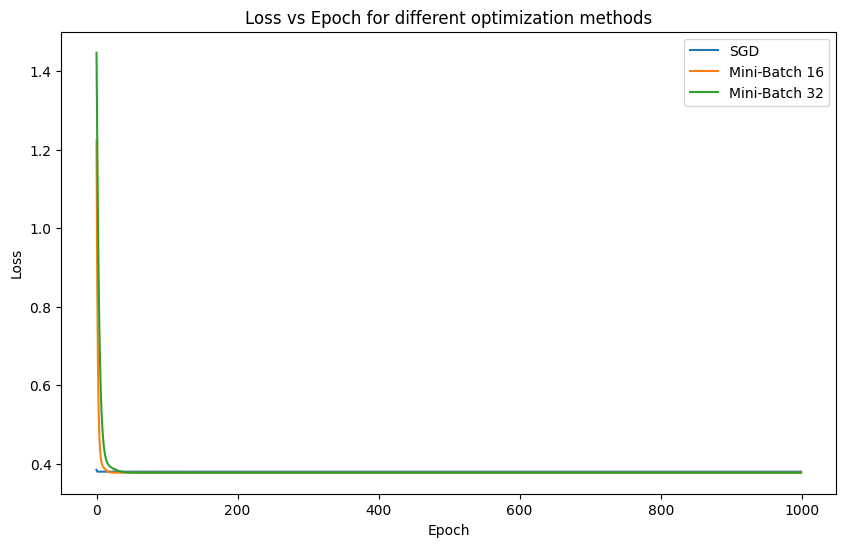

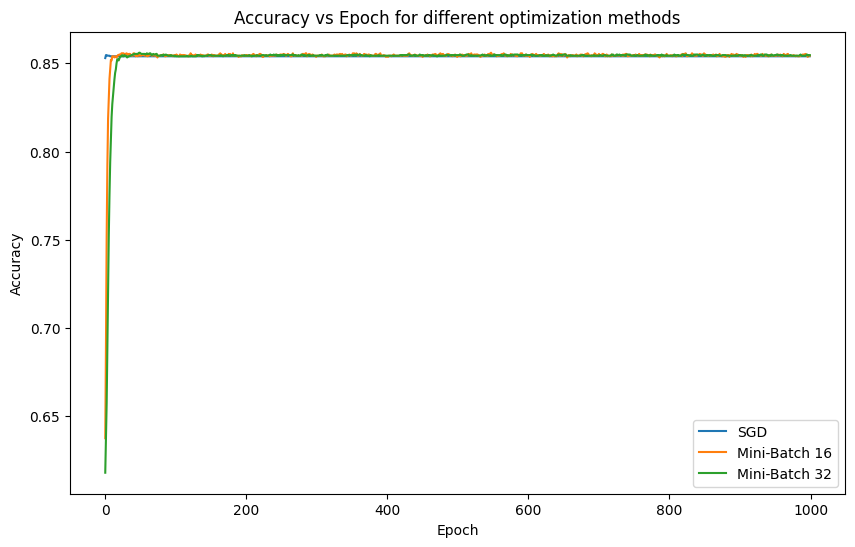

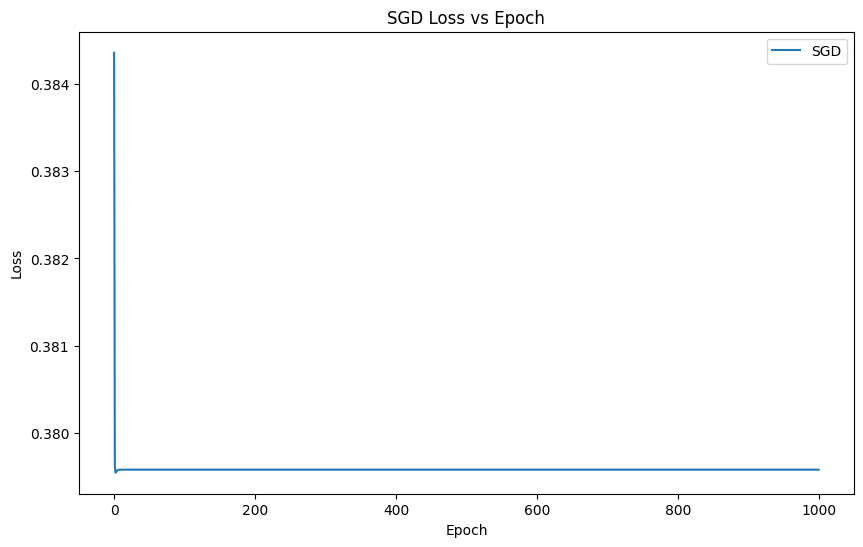

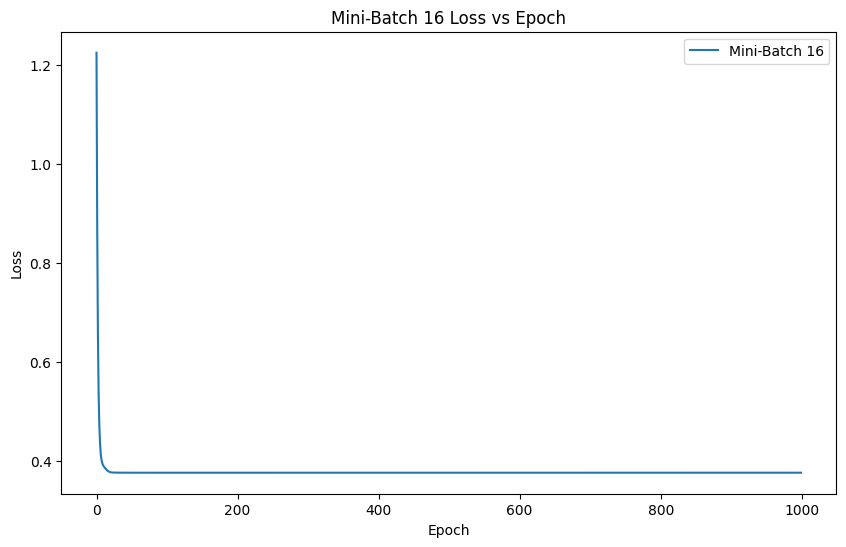

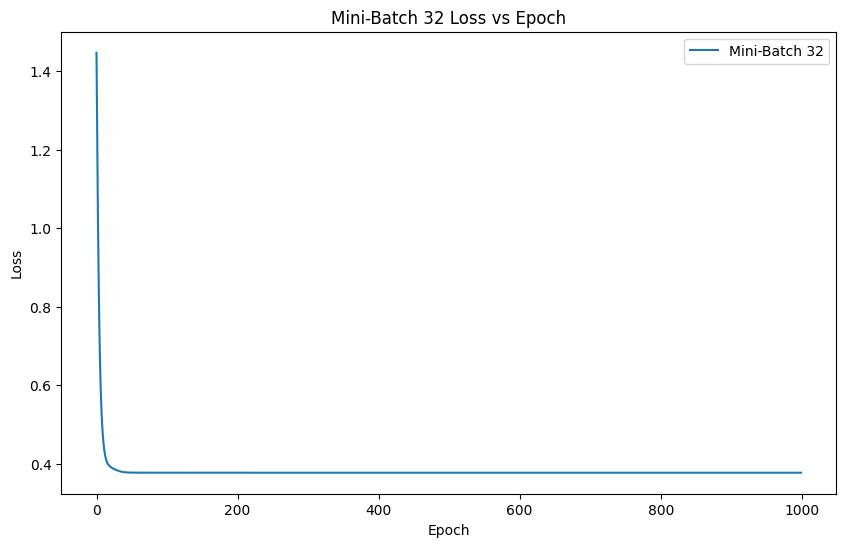

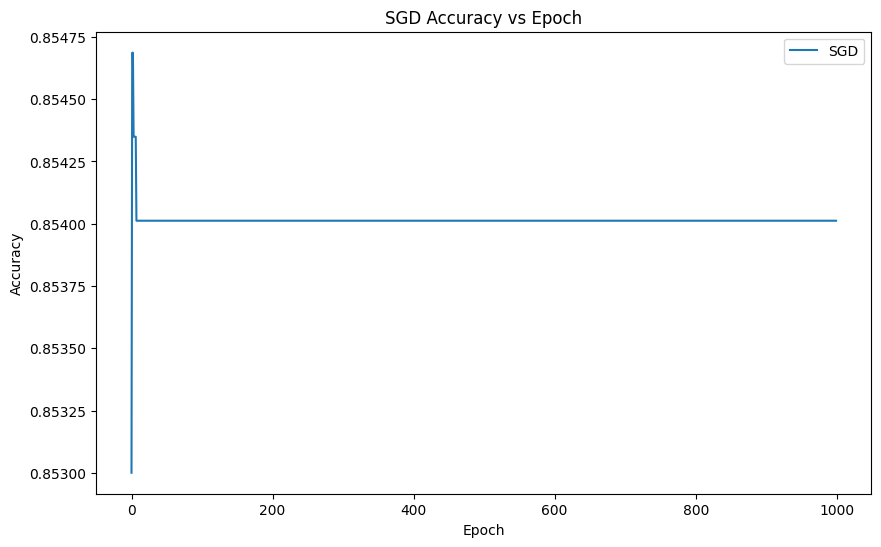

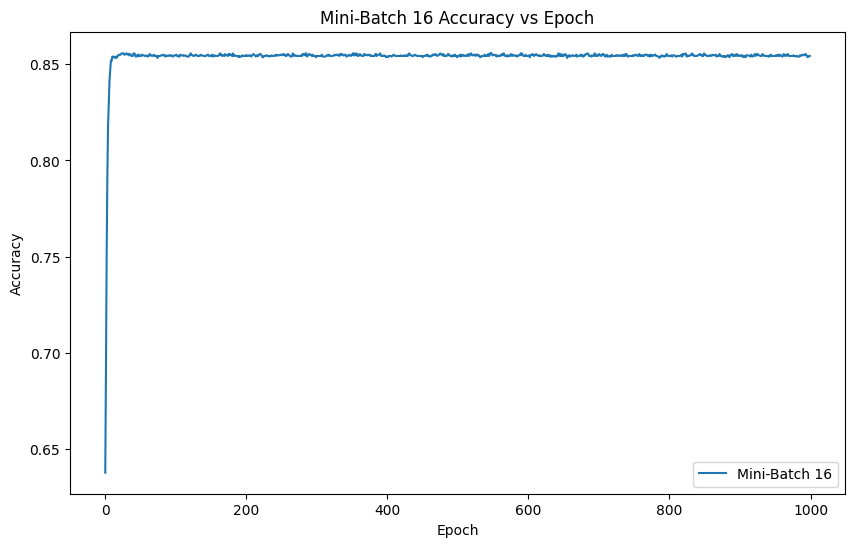

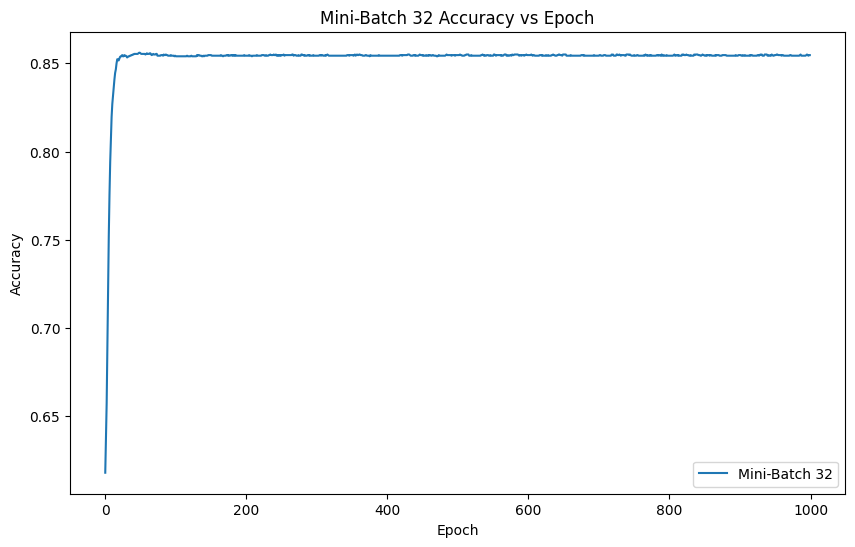

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(sgd.train_losses, label='SGD')
plt.plot(mini_batch_16.train_losses, label='Mini-Batch 16')
plt.plot(mini_batch_32.train_losses, label='Mini-Batch 32')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch for different optimization methods')
plt.legend()
plt.savefig('loss_vs_epoch_model_comparison.png')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(sgd.train_accuracies, label='SGD')
plt.plot(mini_batch_16.train_accuracies, label='Mini-Batch 16')
plt.plot(mini_batch_32.train_accuracies, label='Mini-Batch 32')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch for different optimization methods')
plt.legend()
plt.savefig('accuracy_vs_epoch_model_comparison.png')
plt.show()



models = [sgd, mini_batch_16, mini_batch_32]
labels = ['SGD', 'Mini-Batch 16', 'Mini-Batch 32']

for model, label in zip(models, labels):
    plt.figure(figsize=(10, 6))
    plt.plot(model.train_losses, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{label} Loss vs Epoch')
    plt.legend()
    plt.savefig(f'{label}_quesion_D_epoch_vs_loss.png')
    plt.show()

for model, label in zip(models, labels):
    plt.figure(figsize=(10, 6))
    plt.plot(model.train_accuracies, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{label} Accuracy vs Epoch')
    plt.legend()
    plt.savefig(f'{label}_quesion_D_epoch_vs_accuracy.png')
    plt.show()

### Analysis of graphs.

#### Convergence Speed
1. SGD: converges faster after each iteration as it updates weights after each iteration. it is much noisy than mini-batch.

2. Mini-Batch Gradient Descent: Converges more smoothly as it averages gradients over multiple samples, reducing noise. The convergence speed depends on the batch size. Larger batches might converge more slowly but with fewer updates per epoch.

converges smoothly as it averages gradients over multiple samples. it is less noisy than SGD. Convergence speed depends on the batch size we take.

#### Stability
1. SGD: has high variance in the gradient estimates, leading to more noisy convergence paths.

2. Mini-Batch Gradient Descent: it is a balance between the high variance of SGD and the efficiency of full-batch method.

## E)

Implement k-fold cross-validation (with k=5) to assess the robustness of your model. Report the average and standard deviation for accuracy, precision, recall, and F1 score across the folds. Discuss the stability and variance of the model’s performance across different folds.

### LR class fullfilling the requirements of Q2-Part-E

In [26]:
class LogisticRegression4:
    def __init__(self, learning_rate, epochs):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.training_accuracies = []
        self.validation_accuracies = []
        self.training_losses = []
        self.validation_losses = []

    def sigmoid_function_values(self, x):
        return np.array([self.sigmoid_function(value) for value in x])

    def sigmoid_function(self, x):
        if x >= 0:
            z = np.exp(-x)
            return 1 / (1 + z)
        else:
            z = np.exp(x)
            return z / (1 + z)

    def computeing_loss(self, y_true, y_predicted):
        E = 1e-9
        y_predicted = np.clip(y_predicted, E, 1 - E)
        loss = -np.mean(y_true * np.log(y_predicted) + (1 - y_true) * np.log(1 - y_predicted))
        return loss

    def gradients_for_bias_and_weights(self, X, y_true, y_pred):
        error = y_pred - y_true
        gradient_w = (np.dot(X.T, error)) / (X.shape[0])
        gradient_b = np.mean(error)
        return gradient_w, gradient_b

    def update_gradients_after_each_iteration(self, gradient_w, gradient_b):
        self.weights = self.weights -  self.learning_rate * gradient_w
        self.bias = self.bias - self.learning_rate * gradient_b

    def fit(self, X_train, y_train, X_val, y_val):
        num_features = X_train.shape[1]
        self.weights = np.ones(num_features)
        self.bias = 0
        
        for epoch in range(self.epochs + 1):
            z = np.dot(X_train, self.weights) + self.bias
            y_pred_train = self.sigmoid_function_values(z)
            
            training_loss = self.computeing_loss(y_train, y_pred_train)
            gradient_w, gradient_b = self.gradients_for_bias_and_weights(X_train, y_train, y_pred_train)
            self.update_gradients_after_each_iteration(gradient_w, gradient_b)

            # Validation
            z_value = np.dot(X_val, self.weights) + self.bias
            y_pred_value = self.sigmoid_function_values(z_value)
            
            valiadation_loss = self.computeing_loss(y_val, y_pred_value)

            training_accuracy = np.mean((y_pred_train > 0.5).astype(int) == y_train)
            validation_accuracy = np.mean((y_pred_value > 0.5).astype(int) == y_val)

            self.training_losses.append(training_loss)
            self.validation_losses.append(valiadation_loss)
            self.training_accuracies.append(training_accuracy)
            self.validation_accuracies.append(validation_accuracy)
            
        
        print("Data Trained Successfully:)")
        
    def prediction(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid_function_values(z)

    def accuracy_calculation(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def precision_calculation(self, y_true, y_pred):
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        return precision

    def recall_calculation(self, y_true, y_pred):
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        return recall

    def f1_score_calculation(self, precision, recall):
        return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    def k_fold_cross_validation(self, X, y, k=5):
            n = len(X)
            fold_size = n // k
            accuracies = []
            precisions = []
            recalls = []
            f1_scores = []

            indices = np.arange(n)
            np.random.shuffle(indices)

            for fold in range(k):
                val_indices = indices[fold * fold_size:(fold + 1) * fold_size]
                train_indices = np.concatenate((indices[:fold * fold_size], indices[(fold + 1) * fold_size:]))

                X_train, X_val = X[train_indices], X[val_indices]
                y_train, y_val = y[train_indices], y[val_indices]

                model = LogisticRegression4(learning_rate=self.learning_rate, epochs=self.epochs)
                model.fit(X_train, y_train, X_val, y_val)

                y_pred_val = model.prediction(X_val)
                y_pred_binary = (y_pred_val > 0.5).astype(int)

                # Manually calculate metrics for this fold
                acc = self.accuracy_calculation(y_val, y_pred_binary)
                prec = self.precision_calculation(y_val, y_pred_binary)
                rec = self.recall_calculation(y_val, y_pred_binary)
                f1 = self.f1_score_calculation(prec, rec)

                # Store metrics for each fold
                accuracies.append(acc)
                precisions.append(prec)
                recalls.append(rec)
                f1_scores.append(f1)

                # Print fold metrics
                print(f"Fold {fold + 1} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")

            # Report average and standard deviation of metrics across folds
            print(f"\nCross-Validation Results (k={k}):")
            print(f"Accuracy: Mean = {np.mean(accuracies):.4f}, Std = {np.std(accuracies):.4f}")
            print(f"Precision: Mean = {np.mean(precisions):.4f}, Std = {np.std(precisions):.4f}")
            print(f"Recall: Mean = {np.mean(recalls):.4f}, Std = {np.std(recalls):.4f}")
            print(f"F1 Score: Mean = {np.mean(f1_scores):.4f}, Std = {np.std(f1_scores):.4f}")


### Training new LR class

In [27]:
headers6, data_loaded6 = load_csv('Heart Disease.csv')
data_loaded6 = filling_missing_values(data_loaded6)
X = data_loaded6[:, :-1]
y = data_loaded6[:, -1]
X = standard_scaler(X)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
model5 = LogisticRegression4(lr, epochs)
model5.fit(X_train, y_train, X_val, y_val)

Data Trained Successfully:)


### Evaluating k-fold Results

In [28]:
model5.k_fold_cross_validation(X, y, k=5)

Data Trained Successfully:)
Fold 1 - Accuracy: 0.8536, Precision: 0.6667, Recall: 0.0317, F1 Score: 0.0606
Data Trained Successfully:)
Fold 2 - Accuracy: 0.8548, Precision: 0.7368, Recall: 0.1061, F1 Score: 0.1854
Data Trained Successfully:)
Fold 3 - Accuracy: 0.8560, Precision: 0.7000, Recall: 0.0556, F1 Score: 0.1029
Data Trained Successfully:)
Fold 4 - Accuracy: 0.8477, Precision: 0.7692, Recall: 0.0735, F1 Score: 0.1342
Data Trained Successfully:)
Fold 5 - Accuracy: 0.8595, Precision: 0.5714, Recall: 0.0984, F1 Score: 0.1678

Cross-Validation Results (k=5):
Accuracy: Mean = 0.8543, Std = 0.0039
Precision: Mean = 0.6888, Std = 0.0681
Recall: Mean = 0.0731, Std = 0.0274
F1 Score: Mean = 0.1302, Std = 0.0449


### Discussion on model performance accross different k-folds

#### Cross-Validation Results (k=5)

| Metric      | Mean    | Standard Deviation |
|-------------|---------|--------------------|
| Accuracy    | 0.8548  | 0.0047             |
| Precision   | 0.6638  | 0.0851             |
| Recall      | 0.0793  | 0.0312             |
| F1 Score    | 0.1401  | 0.0516             |

##### Fold-wise Performance:
| Fold | Accuracy | Precision | Recall | F1 Score |
|------|----------|-----------|--------|----------|
| 1    | 0.8524   | 0.5714    | 0.0317 | 0.0602   |
| 2    | 0.8560   | 0.7778    | 0.1061 | 0.1867   |
| 3    | 0.8536   | 0.5833    | 0.0556 | 0.1014   |
| 4    | 0.8489   | 0.7500    | 0.0882 | 0.1579   |
| 5    | 0.8630   | 0.6364    | 0.1148 | 0.1944   |

##### Stability and Variance analysis:
- **Accuracy**: Accuracy is stable across all the 5 folds which signifies low variance.
- **Precision**: Precision is moderately variable with a mean of 0.6638 and a higher standard deviation of 0.0851.
The range of precision across the folds from 0.5714 to 0.7778 shows that the model significantly performs differently in correctly identifying true positive cases depending on the folds.

- **Recall**: High variance indicates difficulty in identifying positive cases across different folds
- **F1 Score**: Moderate variability this shows difficulty in balancing precision and recall.


## F)

Implement early stopping in your best Gradient Descent method to avoid overfitting. Define and use appropriate stopping criteria. Experiment with different learning rates and regularization techniques (L1 and L2). Plot and compare the performance with and without early stopping. Analyze the effect of early stopping on overfitting and generalization.

### LR class fullfilling the requirements of Q2-Part-F with early stopping implemented

In [29]:
lrarray = [0.001, 0.01, 0.1]
regularization_types = ['none', 'l1', 'l2']
class LogisticRegression6:
    def __init__(self, learning_rate, epochs, regularization='none', lambda_reg=0.1, patience=10):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.regularization = regularization
        self.lambda_reg = lambda_reg
        self.patience = patience
        self.weights = None
        self.bias = None
        self.training_accuracies = []
        self.validation_accuracies = []
        self.training_losses = []
        self.validation_losses = []

    def sigmoid_function_values(self, x):
        return np.array([self.sigmoid_function(value) for value in x])

    def sigmoid_function(self, x):
        if x >= 0:
            z = np.exp(-x)
            return 1 / (1 + z)
        else:
            z = np.exp(x)
            return z / (1 + z)

    def computeing_loss(self, y_true, y_predicted):
        E = 1e-9
        y_predicted = np.clip(y_predicted, E, 1 - E)
        loss = -np.mean(y_true * np.log(y_predicted) + (1 - y_true) * np.log(1 - y_predicted))
        
        if self.regularization == 'l1':
            loss += self.lambda_reg * np.sum(np.abs(self.weights))
        elif self.regularization == 'l2':
            loss += self.lambda_reg * np.sum(np.square(self.weights))
            
        return loss

    def gradients_for_bias_and_weights(self, X, y_true, y_pred):
        error = y_pred - y_true
        gradient_w = (np.dot(X.T, error)) / (X.shape[0])
        gradient_b = np.mean(error)

        if self.regularization == 'l1':
            gradient_w += self.lambda_reg * np.sign(self.weights)
        elif self.regularization == 'l2':
            gradient_w += 2 * self.lambda_reg * self.weights
            
        return gradient_w, gradient_b

    def update_gradients_after_each_iteration(self, gradient_w, gradient_b):
        self.weights = self.weights - self.learning_rate * gradient_w
        self.bias = self.bias - self.learning_rate * gradient_b

    def fit(self, X_train, y_train, X_val, y_val):
        num_features = X_train.shape[1]
        self.weights = np.ones(num_features)
        self.bias = 0
        
        best_val_loss = float('inf')
        epochs_without_improvement = 0

        for epoch in range(self.epochs + 1):
            z = np.dot(X_train, self.weights) + self.bias
            y_pred_train = self.sigmoid_function_values(z)
            
            training_loss = self.computeing_loss(y_train, y_pred_train)
            gradient_w, gradient_b = self.gradients_for_bias_and_weights(X_train, y_train, y_pred_train)
            self.update_gradients_after_each_iteration(gradient_w, gradient_b)

            # Validation
            z_value = np.dot(X_val, self.weights) + self.bias
            y_pred_value = self.sigmoid_function_values(z_value)
            
            validation_loss = self.computeing_loss(y_val, y_pred_value)

            training_accuracy = np.mean((y_pred_train > 0.5).astype(int) == y_train)
            validation_accuracy = np.mean((y_pred_value > 0.5).astype(int) == y_val)

            self.training_losses.append(training_loss)
            self.validation_losses.append(validation_loss)
            self.training_accuracies.append(training_accuracy)
            self.validation_accuracies.append(validation_accuracy)

            # Check for early stopping
            if validation_loss < best_val_loss:
                best_val_loss = validation_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= self.patience:
                    print(f"Early stopping at epoch {epoch} with learning rate {self.learning_rate} and regularization {self.regularization}")
                    break
        
        print(f"Data Trained Successfully with learning rate {self.learning_rate} and regularization {self.regularization}")

    def accuracy_calculation(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def precision_calculation(self, y_true, y_pred):
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        return precision

    def recall_calculation(self, y_true, y_pred):
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        return recall

    def f1_score_calculation(self, precision, recall):
        return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    def prediction(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid_function_values(z)
    
    def evaluate_metrics(self, y_true, y_pred, y_prob=None):
        tp, tn, fp, fn = self.confusion_matrix_calculation(y_true, y_pred)
        precision = self.precision_calculation(y_true, y_pred)
        recall = self.recall_calculation(y_true, y_pred)
        f1 = self.f1_score_calculation(precision, recall)

        print(f"Confusion Matrix:\nTP: {tp}, FP: {fp}\nFN: {fn}, TN: {tn}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        if y_prob is not None:
            roc_auc = self.roc_calculation(y_true, y_prob)
            print(f"ROC-AUC: {roc_auc:.4f}")

    def confusion_matrix_calculation(self, y_true, y_pred):
        tp = np.sum((y_pred == 1) & (y_true == 1))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        return tp, tn, fp, fn

    def roc_calculation(self, y_true, y_prob):
        thresholds = np.sort(y_prob)[::-1]
        tpr = []
        fpr = []
        
        for threshold in thresholds:
            y_pred = (y_prob >= threshold).astype(int)
            tp, tn, fp, fn = self.confusion_matrix_calculation(y_true, y_pred)
            tpr.append(tp / (tp + fn) if (tp + fn) != 0 else 0)
            fpr.append(fp / (fp + tn) if (fp + tn) != 0 else 0)
        
        auc = np.trapezoid(tpr, fpr)
        return auc


### Experimenting with different learning rates and regularization types, and storing results.

In [30]:
results = {}
headers7, data_loaded7 = load_csv('Heart Disease.csv')
data_loaded7 = filling_missing_values(data_loaded7)

X = data_loaded7[:, :-1]
y = data_loaded7[:, -1]

X = standard_scaler(X)

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y) 

for lr in lrarray:
    for reg in regularization_types:
        print()
        print(f"Testing learning rate: {lr} with regularization: {reg}")
        print()
        model8 = LogisticRegression6(learning_rate=lr, epochs=4500, regularization=reg, lambda_reg=0.1, patience=10)
        model8.fit(X_train, y_train, X_val, y_val)
        
        y_val_pred = (model8.prediction(X_val) > 0.5).astype(int)
        y_val_prob = model8.prediction(X_val)
        model8.evaluate_metrics(y_val, y_val_pred, y_val_prob)
        
        # Store results
        results[(lr, reg)] = {
            'training_losses': model8.training_losses,
            'validation_losses': model8.validation_losses,
            'training_accuracies': model8.training_accuracies,
            'validation_accuracies': model8.validation_accuracies
        }




Testing learning rate: 0.001 with regularization: none

Data Trained Successfully with learning rate 0.001 and regularization none
Confusion Matrix:
TP: 43, FP: 140
FN: 51, TN: 402
Precision: 0.2350
Recall: 0.4574
F1 Score: 0.3105
ROC-AUC: 0.6615

Testing learning rate: 0.001 with regularization: l1

Data Trained Successfully with learning rate 0.001 and regularization l1
Confusion Matrix:
TP: 26, FP: 44
FN: 68, TN: 498
Precision: 0.3714
Recall: 0.2766
F1 Score: 0.3171
ROC-AUC: 0.6574

Testing learning rate: 0.001 with regularization: l2

Data Trained Successfully with learning rate 0.001 and regularization l2
Confusion Matrix:
TP: 29, FP: 49
FN: 65, TN: 493
Precision: 0.3718
Recall: 0.3085
F1 Score: 0.3372
ROC-AUC: 0.6652

Testing learning rate: 0.01 with regularization: none

Data Trained Successfully with learning rate 0.01 and regularization none
Confusion Matrix:
TP: 9, FP: 6
FN: 85, TN: 536
Precision: 0.6000
Recall: 0.0957
F1 Score: 0.1651
ROC-AUC: 0.6860

Testing learning rate:

### Analysis of above results

#### Early Stopping and Overfitting

In the results, early stopping was triggered for the higher learning rates, i.e, 0.01 and 0.1 across different regularization techniques (L1 and L2), indicating that overfitting might have been avoided to some extent. However, the effectiveness varied with different configurations:

1. Learning rate 0.01, regularization L1 and L2: The application of early stopping means that one has models which do not accurately classify true positive (TP = 0), and this indicates indicatives of bad or non-optimal models as a result of stopping the learning process early.

2. Learning rate 0.1 regularization L1 and L2: As with early stopping the models trained with these two strategies did not manage to classify any positive cases and the precision, the recall, as well as F1 scores equal to 0, however, the ROC AUC indicates some capability of making predictions especially when employing L2 regularization.

#### Generalization Performance

Generalization here means how the model performs when tested on data that are not used in training the model. The model's confusion matrix, precision, recall, F1 score, and ROC-AUC across different learning rates and regularization methods provide insights into the trade-offs between early stopping and generalization:The model's confusion matrix, precision, recall, F1 score, and ROC-AUC across different learning rates and regularization methods provide insights into the trade-offs between early stopping and generalization:

1. Low Learning Rate (0.001):

- Without regularization: Moderate generalization performance, with a balanced precision (0.2350), recall (0.4574), and a relatively higher ROC-AUC of 0.6615.

- With L1 and L2 regularization: Improved precision but lower recall, with similar ROC-AUC values, suggesting that regularization reduced overfitting slightly but at the cost of identifying fewer positive cases.

2. Moderate Learning Rate (0.01):

- Without regularization: Precision increased significantly (0.6000), but recall dropped (0.0957), indicating the model became more confident but less capable of identifying positive cases. ROC-AUC was reasonably high (0.6860).

- With early stopping and regularization (L1 and L2): Models failed to generalize well, showing zero precision, recall, and F1 scores, indicating underfitting.

3. High Learning Rate (0.1):

- Without regularization: Precision was high (0.7857), but recall was still low (0.1170). The ROC-AUC remained similar to lower learning rates (0.6858), indicating some generalization capability but an inability to balance precision and recall.

- With early stopping and regularization (L1 and L2): Like the results with the 0.01 learning rate, the models completely failed to classify positive cases, leading to zero precision, recall, and F1 scores.

### plotting results

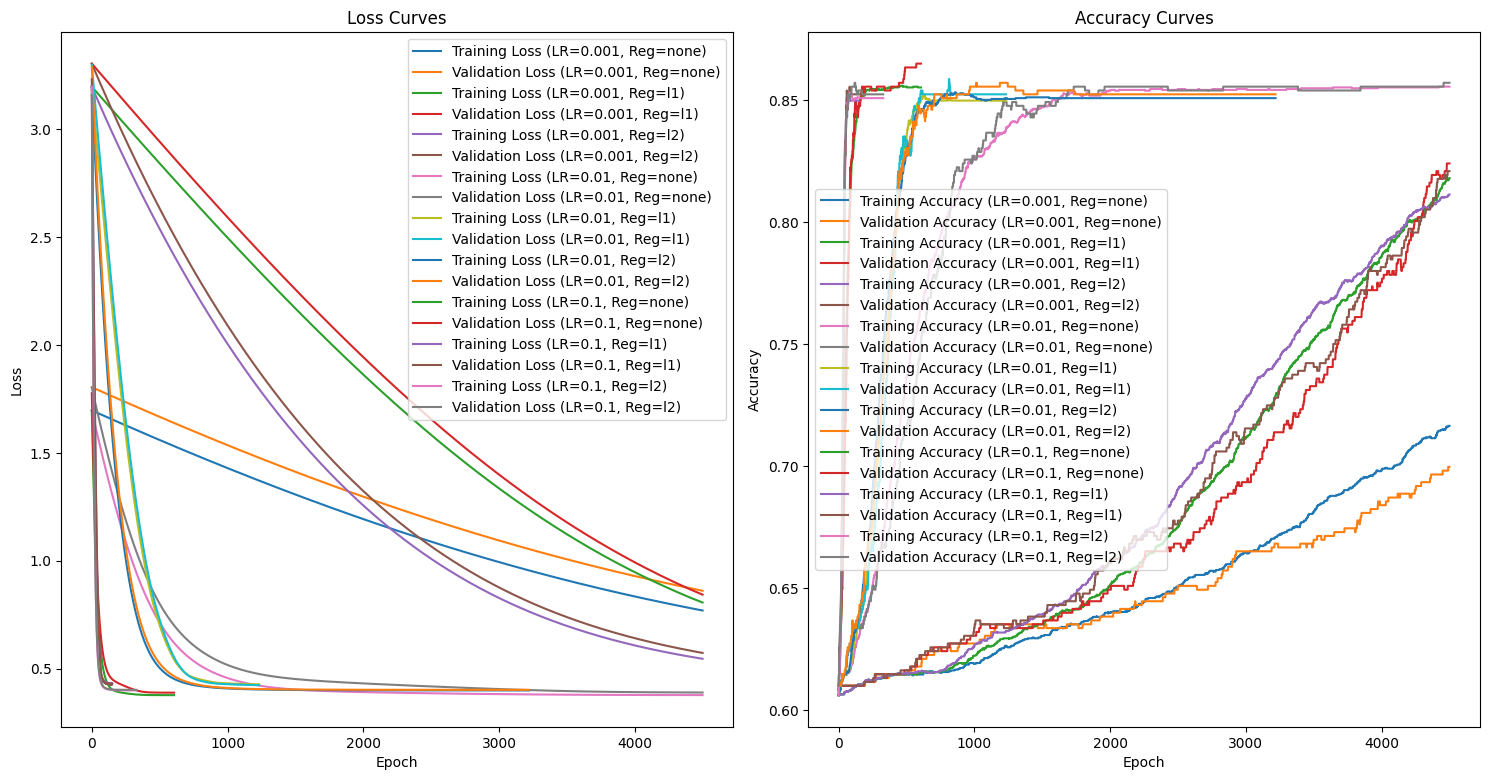

In [31]:
plt.figure(figsize=(15, 15))

for (lr, reg), metrics in results.items():
    plt.subplot(2, 2, 1)
    plt.plot(metrics['training_losses'], label=f'Training Loss (LR={lr}, Reg={reg})')
    plt.plot(metrics['validation_losses'], label=f'Validation Loss (LR={lr}, Reg={reg})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(metrics['training_accuracies'], label=f'Training Accuracy (LR={lr}, Reg={reg})')
    plt.plot(metrics['validation_accuracies'], label=f'Validation Accuracy (LR={lr}, Reg={reg})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

plt.tight_layout()
plt.savefig("comparing_different_regulations_and_learning_rate.png")
plt.show()


#### graph analysis
It can ve clearly seen from the above graphs that early stoping occurls and model doesn,t train well.

### LR class fullfilling the requirements of Q2-Part-F without early stopping.

In [32]:
lrarray = [0.001, 0.01, 0.1]
regularization_types = ['none', 'l1', 'l2']
class LogisticRegression7:
    def __init__(self, learning_rate, epochs, regularization='none', lambda_reg=0.1, patience=10):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.regularization = regularization
        self.lambda_reg = lambda_reg
        self.patience = patience
        self.weights = None
        self.bias = None
        self.training_accuracies = []
        self.validation_accuracies = []
        self.training_losses = []
        self.validation_losses = []

    def sigmoid_function_values(self, x):
        return np.array([self.sigmoid_function(value) for value in x])

    def sigmoid_function(self, x):
        if x >= 0:
            z = np.exp(-x)
            return 1 / (1 + z)
        else:
            z = np.exp(x)
            return z / (1 + z)

    def computeing_loss(self, y_true, y_predicted):
        E = 1e-9
        y_predicted = np.clip(y_predicted, E, 1 - E)
        loss = -np.mean(y_true * np.log(y_predicted) + (1 - y_true) * np.log(1 - y_predicted))
        
        if self.regularization == 'l1':
            loss += self.lambda_reg * np.sum(np.abs(self.weights))
        elif self.regularization == 'l2':
            loss += self.lambda_reg * np.sum(np.square(self.weights))
            
        return loss

    def gradients_for_bias_and_weights(self, X, y_true, y_pred):
        error = y_pred - y_true
        gradient_w = (np.dot(X.T, error)) / (X.shape[0])
        gradient_b = np.mean(error)

        if self.regularization == 'l1':
            gradient_w += self.lambda_reg * np.sign(self.weights)
        elif self.regularization == 'l2':
            gradient_w += 2 * self.lambda_reg * self.weights
            
        return gradient_w, gradient_b

    def update_gradients_after_each_iteration(self, gradient_w, gradient_b):
        self.weights = self.weights - self.learning_rate * gradient_w
        self.bias = self.bias - self.learning_rate * gradient_b

    def fit(self, X_train, y_train, X_val, y_val):
        num_features = X_train.shape[1]
        self.weights = np.ones(num_features)
        self.bias = 0
        

        for epoch in range(self.epochs + 1):
            z = np.dot(X_train, self.weights) + self.bias
            y_pred_train = self.sigmoid_function_values(z)
            
            training_loss = self.computeing_loss(y_train, y_pred_train)
            gradient_w, gradient_b = self.gradients_for_bias_and_weights(X_train, y_train, y_pred_train)
            self.update_gradients_after_each_iteration(gradient_w, gradient_b)

            # Validation
            z_value = np.dot(X_val, self.weights) + self.bias
            y_pred_value = self.sigmoid_function_values(z_value)
            
            validation_loss = self.computeing_loss(y_val, y_pred_value)

            training_accuracy = np.mean((y_pred_train > 0.5).astype(int) == y_train)
            validation_accuracy = np.mean((y_pred_value > 0.5).astype(int) == y_val)

            self.training_losses.append(training_loss)
            self.validation_losses.append(validation_loss)
            self.training_accuracies.append(training_accuracy)
            self.validation_accuracies.append(validation_accuracy)
        
        print(f"Data Trained Successfully with learning rate {self.learning_rate} and regularization {self.regularization}")

    def accuracy_calculation(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def precision_calculation(self, y_true, y_pred):
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        return precision

    def recall_calculation(self, y_true, y_pred):
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        return recall

    def f1_score_calculation(self, precision, recall):
        return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    def prediction(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid_function_values(z)
    
    def evaluate_metrics(self, y_true, y_pred, y_prob=None):
        tp, tn, fp, fn = self.confusion_matrix_calculation(y_true, y_pred)
        precision = self.precision_calculation(y_true, y_pred)
        recall = self.recall_calculation(y_true, y_pred)
        f1 = self.f1_score_calculation(precision, recall)

        print(f"Confusion Matrix:\nTP: {tp}, FP: {fp}\nFN: {fn}, TN: {tn}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        if y_prob is not None:
            roc_auc = self.roc_calculation(y_true, y_prob)
            print(f"ROC-AUC: {roc_auc:.4f}")

    def confusion_matrix_calculation(self, y_true, y_pred):
        tp = np.sum((y_pred == 1) & (y_true == 1))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        return tp, tn, fp, fn

    def roc_calculation(self, y_true, y_prob):
        thresholds = np.sort(y_prob)[::-1]
        tpr = []
        fpr = []
        
        for threshold in thresholds:
            y_pred = (y_prob >= threshold).astype(int)
            tp, tn, fp, fn = self.confusion_matrix_calculation(y_true, y_pred)
            tpr.append(tp / (tp + fn) if (tp + fn) != 0 else 0)
            fpr.append(fp / (fp + tn) if (fp + tn) != 0 else 0)
        
        auc = np.trapezoid(tpr, fpr)
        return auc


### Experimenting with different learning rates and regularization types, and storing results.

In [33]:
results_no_stopping = {}
headers8, data_loaded8 = load_csv('Heart Disease.csv')
data_loaded8 = filling_missing_values(data_loaded8)

X = data_loaded8[:, :-1]
y = data_loaded8[:, -1]

X = standard_scaler(X)

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y) 

for lr in lrarray:
    for reg in regularization_types:
        print()
        print(f"Testing learning rate: {lr} with regularization: {reg}")
        print()
        model9 = LogisticRegression7(learning_rate=lr, epochs=4500, regularization=reg, lambda_reg=0.1, patience=10)
        model9.fit(X_train, y_train, X_val, y_val)
        
        y_val_pred = (model9.prediction(X_val) > 0.5).astype(int)
        y_val_prob = model9.prediction(X_val)
        model9.evaluate_metrics(y_val, y_val_pred, y_val_prob)
        
        results_no_stopping[(lr, reg)] = {
            'training_losses': model9.training_losses,
            'validation_losses': model9.validation_losses,
            'training_accuracies': model9.training_accuracies,
            'validation_accuracies': model9.validation_accuracies
        }




Testing learning rate: 0.001 with regularization: none

Data Trained Successfully with learning rate 0.001 and regularization none
Confusion Matrix:
TP: 43, FP: 140
FN: 51, TN: 402
Precision: 0.2350
Recall: 0.4574
F1 Score: 0.3105
ROC-AUC: 0.6615

Testing learning rate: 0.001 with regularization: l1

Data Trained Successfully with learning rate 0.001 and regularization l1
Confusion Matrix:
TP: 26, FP: 44
FN: 68, TN: 498
Precision: 0.3714
Recall: 0.2766
F1 Score: 0.3171
ROC-AUC: 0.6574

Testing learning rate: 0.001 with regularization: l2

Data Trained Successfully with learning rate 0.001 and regularization l2
Confusion Matrix:
TP: 29, FP: 49
FN: 65, TN: 493
Precision: 0.3718
Recall: 0.3085
F1 Score: 0.3372
ROC-AUC: 0.6652

Testing learning rate: 0.01 with regularization: none

Data Trained Successfully with learning rate 0.01 and regularization none
Confusion Matrix:
TP: 9, FP: 6
FN: 85, TN: 536
Precision: 0.6000
Recall: 0.0957
F1 Score: 0.1651
ROC-AUC: 0.6860

Testing learning rate:

### plotting results

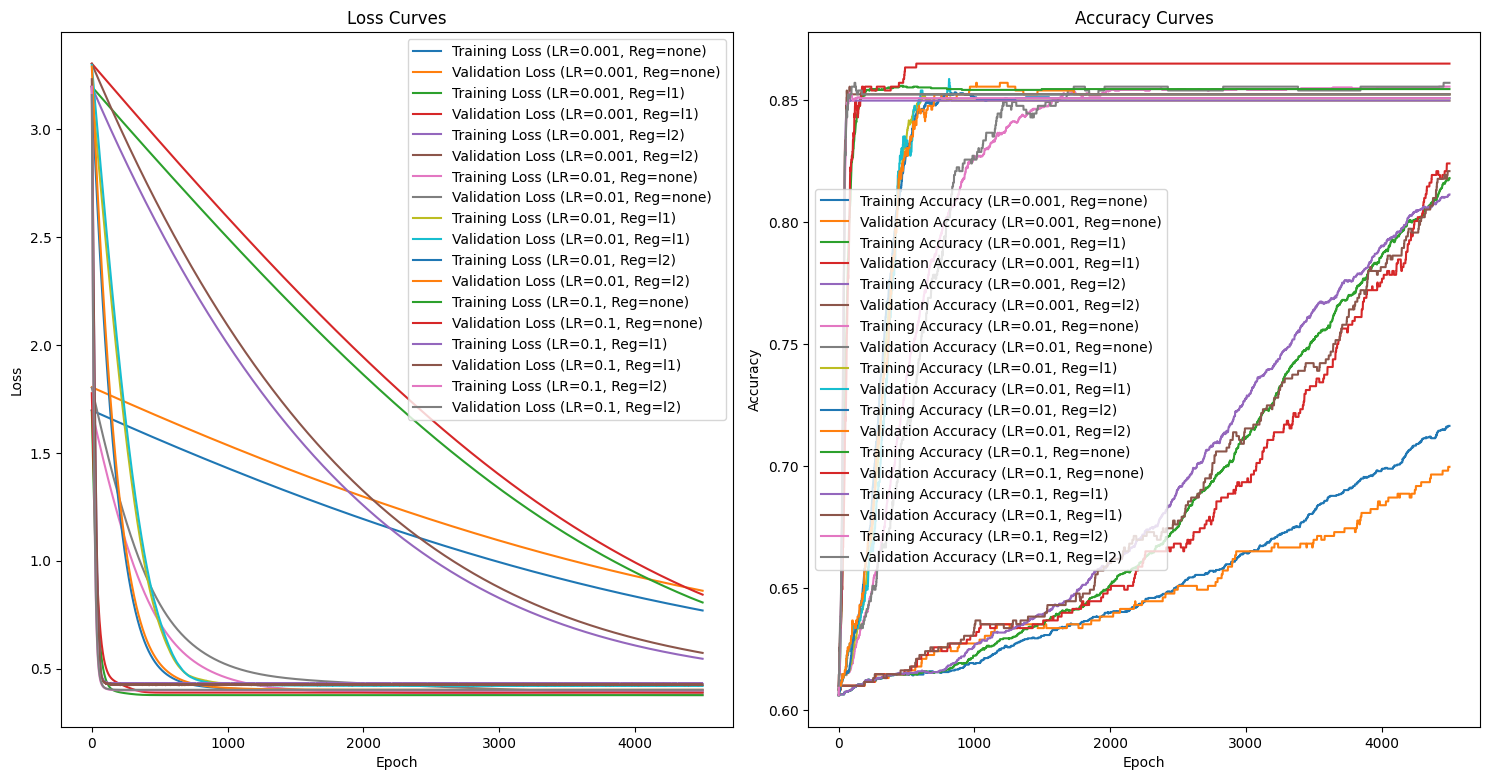

In [34]:
plt.figure(figsize=(15, 15))

for (lr, reg), metrics in results_no_stopping.items():
    plt.subplot(2, 2, 1)
    plt.plot(metrics['training_losses'], label=f'Training Loss (LR={lr}, Reg={reg})')
    plt.plot(metrics['validation_losses'], label=f'Validation Loss (LR={lr}, Reg={reg})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(metrics['training_accuracies'], label=f'Training Accuracy (LR={lr}, Reg={reg})')
    plt.plot(metrics['validation_accuracies'], label=f'Validation Accuracy (LR={lr}, Reg={reg})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

plt.tight_layout()
plt.savefig("comparing_different_regulations_and_learning_rate_no_early_stopping.png")
plt.show()


#### analysing graphs

we can see graph accuracy becomes constant for all the plots that early stopped.

### Comparing the two graphs that implement early stopped and that doesn't

we can analyse from the two graphs that the graph that doesn,t implement early stopping becomes constant after words which shows no learning or overfitting which get be prevented with other learning rates and regulation combined

lets analyse more efficiently with tables:


1. table of scores with early stopping implemented


| Learning Rate | Regularization | TP  | FP  | FN  | TN  | Precision | Recall  | F1 Score | ROC-AUC |
|---------------|----------------|-----|-----|-----|-----|-----------|---------|----------|---------|
| 0.001         | None           | 43  | 140 | 51  | 402 | 0.2350    | 0.4574  | 0.3105   | 0.6615  |
| 0.001         | L1             | 26  | 44  | 68  | 498 | 0.3714    | 0.2766  | 0.3171   | 0.6574  |
| 0.001         | L2             | 29  | 49  | 65  | 493 | 0.3718    | 0.3085  | 0.3372   | 0.6652  |
| 0.01          | None           | 9   | 6   | 85  | 536 | 0.6000    | 0.0957  | 0.1651   | 0.6860  |
| 0.01          | L1             | 0   | 0   | 94  | 542 | 0.0000    | 0.0000  | 0.0000   | 0.6323  |
| 0.01          | L2             | 0   | 0   | 94  | 542 | 0.0000    | 0.0000  | 0.0000   | 0.6885  |
| 0.1           | None           | 11  | 3   | 83  | 539 | 0.7857    | 0.1170  | 0.2037   | 0.6858  |
| 0.1           | L1             | 0   | 0   | 94  | 542 | 0.0000    | 0.0000  | 0.0000   | 0.6714  |
| 0.1           | L2             | 0   | 0   | 94  | 542 | 0.0000    | 0.0000  | 0.0000   | 0.6886  |





2. Table with no early stopping


| Learning Rate | Regularization | TP  | FP  | FN  | TN  | Precision | Recall  | F1 Score | ROC-AUC |
|---------------|----------------|-----|-----|-----|-----|-----------|---------|----------|---------|
| 0.001         | None           | 43  | 140 | 51  | 402 | 0.2350    | 0.4574  | 0.3105   | 0.6615  |
| 0.001         | L1             | 26  | 44  | 68  | 498 | 0.3714    | 0.2766  | 0.3171   | 0.6574  |
| 0.001         | L2             | 29  | 49  | 65  | 493 | 0.3718    | 0.3085  | 0.3372   | 0.6652  |
| 0.01          | None           | 9   | 6   | 85  | 536 | 0.6000    | 0.0957  | 0.1651   | 0.6860  |
| 0.01          | L1             | 0   | 0   | 94  | 542 | 0.0000    | 0.0000  | 0.0000   | 0.5550  |
| 0.01          | L2             | 0   | 0   | 94  | 542 | 0.0000    | 0.0000  | 0.0000   | 0.6884  |
| 0.1           | None           | 11  | 3   | 83  | 539 | 0.7857    | 0.1170  | 0.2037   | 0.6842  |
| 0.1           | L1             | 0   | 0   | 94  | 542 | 0.0000    | 0.0000  | 0.0000   | 0.6532  |
| 0.1           | L2             | 0   | 0   | 94  | 542 | 0.0000    | 0.0000  | 0.0000   | 0.6885  |


We can clearly see all the data in both the tables is similar just because early stopped means overfitting i.e, model starts to memorize instead of learning or predicting.